In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO("Models/model_det_fp32/best.pt")  # load an official model

# Retrieve metadata during export. Metadata needs to be added to config.pbtxt. See next section.
metadata = []


def export_cb(exporter):
    metadata.append(exporter.metadata)


model.add_callback("on_export_end", export_cb)

# Export the model
onnx_file = model.export(format="onnx", dynamic=True)

Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.8.0.dev20250408+cu128 CPU (Intel Xeon Gold 5315Y 3.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'Models/model_det_fp32/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirement ['onnxruntime'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 12.6s, saved as 'Models/model_det_fp32/best.onnx' (11.6 MB)

Export complete (12.9s)
Results saved to /home/paperspace/project_conveyer/Models/model_det_fp32
Predict:         yolo predict task=detect model=Models/model_det_fp32/best.onnx imgsz=640  
Validate:        yolo val task=detect model=Models/model_det_fp32/best.onnx imgsz=640 data=C:\Users\Asus Rog Strix\Desktop\Multimodal\potato check.v4i.yolov8\data.yaml  
Visualize: 

In [2]:
from pathlib import Path

# Define paths
model_name = "yolo"
triton_repo_path = Path("tmp") / "triton_repo"
triton_model_path = triton_repo_path / model_name

# Create directories
(triton_model_path / "1").mkdir(parents=True, exist_ok=True)

In [3]:
from pathlib import Path

# Move ONNX model to Triton Model path
Path(onnx_file).rename(triton_model_path / "1" / "model.onnx")

# Create config file
(triton_model_path / "config.pbtxt").touch()

data = """
# Add metadata
parameters {
  key: "metadata"
  value {
    string_value: "%s"
  }
}

# (Optional) Enable TensorRT for GPU inference
# First run will be slow due to TensorRT engine conversion
optimization {
  execution_accelerators {
    gpu_execution_accelerator {
      name: "tensorrt"
      parameters {
        key: "precision_mode"
        value: "FP16"
      }
      parameters {
        key: "max_workspace_size_bytes"
        value: "3221225472"
      }
      parameters {
        key: "trt_engine_cache_enable"
        value: "1"
      }
      parameters {
        key: "trt_engine_cache_path"
        value: "/models/yolo/1"
      }
    }
  }
}
""" % metadata[0]  # noqa

with open(triton_model_path / "config.pbtxt", "w") as f:
    f.write(data)

In [5]:
import contextlib
import subprocess
import time

from tritonclient.http import InferenceServerClient

# Define image https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
tag = "nvcr.io/nvidia/tritonserver:25.03-py3"  # 8.57 GB

# Pull the image
subprocess.call(f"docker pull {tag}", shell=True)

# Run the Triton server and capture the container ID
container_id = (
    subprocess.check_output(
        f"sudo docker run -d --rm --gpus 0 -v {triton_repo_path}:/models -p 8000:8000 {tag} tritonserver --model-repository=/models",
        shell=True,
    )
    .decode("utf-8")
    .strip()
)

# Wait for the Triton server to start
triton_client = InferenceServerClient(url="localhost:8000", verbose=False, ssl=False)

# Wait until model is ready
for _ in range(10):
    with contextlib.suppress(Exception):
        assert triton_client.is_model_ready(model_name)
        break
    time.sleep(1)

25.03-py3: Pulling from nvidia/tritonserver
Digest: sha256:517c069d37327883715bb548e5db52ebd5bead0faffb9add3f2eb8aa2b81a047
Status: Image is up to date for nvcr.io/nvidia/tritonserver:25.03-py3
nvcr.io/nvidia/tritonserver:25.03-py3


docker: Error response from daemon: create tmp/triton_repo: "tmp/triton_repo" includes invalid characters for a local volume name, only "[a-zA-Z0-9][a-zA-Z0-9_.-]" are allowed. If you intended to pass a host directory, use absolute path

Run 'docker run --help' for more information


CalledProcessError: Command 'sudo docker run -d --rm --gpus 0 -v tmp/triton_repo:/models -p 8000:8000 nvcr.io/nvidia/tritonserver:25.03-py3 tritonserver --model-repository=/models' returned non-zero exit status 125.

In [6]:
# Wait for the Triton server to start
triton_client = InferenceServerClient(url="localhost:8000", verbose=False, ssl=False)

# Wait until model is ready
for _ in range(10):
    with contextlib.suppress(Exception):
        assert triton_client.is_model_ready(model_name)
        break
    time.sleep(1)

In [7]:
from ultralytics import YOLO

# Load the Triton Server model
model = YOLO("http://localhost:8000/yolo", task="detect")

# Run inference on the server
results = model("frame.jpg")

InferenceServerException: [404] Request for unknown model: 'yolo' is not found

In [1]:
import cv2
import numpy as np
img = cv2.imread('frame.jpg')
input_image = np.array([img for i in range(20)])
input_image = (input_image / 255.0).astype(np.float32)

In [22]:
import numpy as np
from tritonclient.utils import triton_to_np_dtype
from tritonclient.http import InferenceServerClient, InferInput

# Assuming 'input_name' is the name of your model's input tensor
input_name = 'images'
input_shape = (20, 3, 640, 640)
input_dtype = 'FP32'

# Create a dummy input data with the expected shape
input_data = np.random.rand(*input_shape).astype(triton_to_np_dtype(input_dtype))

# Initialize the Triton client
client = InferenceServerClient(url='localhost:8000')

# Create the InferInput object and set the data
infer_input = InferInput(input_name, input_shape, input_dtype)
infer_input.set_data_from_numpy(input_data)

# Send inference request
response = client.infer(model_name='model_det', inputs=[infer_input])

In [ ]:
def preprocess(image):
    input_name = 'images'
    input_shape = (1, 3, 640, 640)
    input_dtype = 'FP32'

    original_h, original_w = image.shape[:2]
    scale_w = original_w / 640.0
    scale_h = original_h / 640.0

    input_data = (cv2.resize(image, (640, 640)) / 255.0).astype(triton_to_np_dtype(input_dtype))
    input_data = input_data.transpose(2, 0, 1)  # (C, H, W)
    input_data = np.expand_dims(input_data, axis=0)  # (1, C, H, W)

    infer_input = InferInput(input_name, input_shape, input_dtype)
    infer_input.set_data_from_numpy(input_data)

    return infer_input, (scale_w, scale_h)

In [164]:
import torch
import torchvision.ops as ops
import numpy as np

def det_postprocess(output, conf_thres=0.0005, iou_thres=0.9, img_size=640):
    """
    Postprocess YOLOv8 ONNX output with shape [5, 8400].

    Args:
        output (np.ndarray or torch.Tensor): Model output [5, 8400].
        conf_thres (float): Confidence threshold.
        iou_thres (float): IoU threshold for NMS.
        img_size (int): Model input size (usually 640).

    Returns:
        Tensor of shape [num_detections, 5] — [x1, y1, x2, y2, score]
    """
    # Ensure tensor
    if isinstance(output, np.ndarray):
        output = torch.from_numpy(output)

    # Move from [5, 8400] → [8400, 5]
    output = output.permute(1, 0).contiguous()

    # Filter by confidence
    scores = output[:, 4]
    mask = scores > conf_thres
    boxes = output[mask][:, :4]
    scores = scores[mask]

    if boxes.numel() == 0:
        return torch.empty((0, 5))

    # Convert [x_center, y_center, w, h] → [x1, y1, x2, y2]
    boxes_xyxy = torch.zeros_like(boxes)
    boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2
    boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2
    boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2
    boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2

    # Apply NMS
    keep = ops.nms(boxes_xyxy, scores, iou_thres)
    boxes_final = boxes_xyxy[keep]
    scores_final = scores[keep]

    return torch.cat([boxes_final, scores_final.unsqueeze(1)], dim=1)


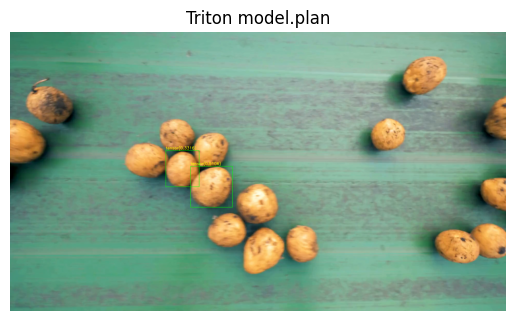

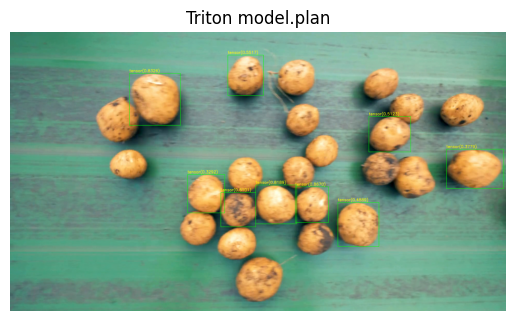

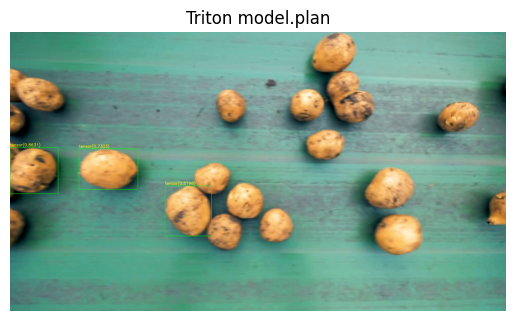

[vost#0:0/rawvideo @ 0x55b511adbbc0] Error submitting a packet to the muxer: Broken pipe
    Last message repeated 1 times
[out#0/rawvideo @ 0x55b511af9300] Error muxing a packet
[out#0/rawvideo @ 0x55b511af9300] Task finished with error code: -32 (Broken pipe)
[out#0/rawvideo @ 0x55b511af9300] Terminating thread with return code -32 (Broken pipe)
[out#0/rawvideo @ 0x55b511af9300] Error writing trailer: Broken pipe
[out#0/rawvideo @ 0x55b511af9300] Error closing file: Broken pipe


KeyboardInterrupt: 

In [165]:
import cv2
import ffmpegcv
import numpy as np
from matplotlib import pyplot as plt
from tritonclient.http import InferenceServerClient

# Function to draw boxes
def draw_boxes(image, boxes, scale=(1.0, 1.0), class_names=None, color=(0, 255, 0)):
    image = image.copy()
    for box in boxes:
        x1, y1, x2, y2 = [int(coord) for coord in box[:4]]
        x1 = int(x1*scale_w)
        x2 = int(x2*scale_w)
        y1 = int(y1*scale_h)
        y2 = int(y2*scale_h)
        score = box[4] if len(box) > 4 else None
        class_id = int(box[5]) if len(box) > 5 else None
        
        label = ''
        if class_names and class_id is not None:
            label = f"{class_names[class_id]} {score:.2f}" if score is not None else class_names[class_id]
        elif score is not None:
            label = f"{score:.2f}"

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, str(score), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    return image

# Your inference loop
client = InferenceServerClient(url='localhost:8000')


with ffmpegcv.VideoCapture('video.mp4') as cap:

    for iframe, frame in enumerate(cap):
        if iframe > 100:
            break

        infer_input, (scale_w, scale_h)= preprocess(frame)  # preprocess returns the input for inference
        response = client.infer(model_name='model_det', inputs=[infer_input])
        output0 = response.as_numpy('output0')  # output0[0] assumed to be detections
        
        # Draw boxes
        if iframe % 30 == 0:
            frame_with_boxes = draw_boxes(frame, results, (scale_w, scale_h), class_names='potato')

            # Show with matplotlib
            plt.imshow(cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(f"Triton model.plan")
            plt.axis('off')
            plt.show()


In [158]:
from ultralytics import YOLO

model = YOLO('Models/tets/best.pt')
model.export(format='onnx', dynamic=True, batch=20, imgsz=640)

Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.8.0.dev20250408+cu128 CPU (Intel Xeon Gold 5315Y 3.20GHz)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'Models/tets/best.pt' with input shape (20, 3, 640, 640) BCHW and output shape(s) (20, 5, 8400) (6.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
[W] trt-runner-N5-04/10/25-22:17:10     | Was activated but never deactivated. This could cause a memory leak!
[W] trt-runner-N7-04/10/25-22:25:03     | Was activated but never deactivated. This could cause a memory leak!
ONNX: export success ✅ 12.2s, saved as 'Models/tets/best.onnx' (11.6 MB)

Export complete (13.8s)
Results saved to /home/paperspace/project_conveyer/Models/tets
Predict:         yolo predict task=detect model=Models/tets/best.onnx imgsz=640  
Validate:        yolo val task=detect model=Models/tets/best.onnx imgsz=640 data=C:\Users\Asus Rog Strix\Desktop\Multimodal\potato check.v4i.yolov8\data.yaml  
Visualize:       https://netron.app


'Models/tets/best.onnx'

In [151]:
model = YOLO("Models/best.pt")
results = model.predict(imgs, imgsz=640, conf=0.5, ag)
torch_outputs = results[0].boxes.data.cpu().numpy()  # Тензоры с боксами


0: 384x640 17 potatos, 6.6ms
Speed: 3.5ms preprocess, 6.6ms inference, 19.5ms postprocess per image at shape (1, 3, 384, 640)


In [154]:
import numpy as np
from PIL import Image
from ultralytics import YOLO

model = YOLO("Models/best.pt")
image = Image.open("frame.jpg")
ret = model.predict("frame.jpg") # doing this prediction is mandatory for the model to instantiate self.predictor with the right arguments
im = model.predictor.preprocess(np.array(image)[np.newaxis, ...])
preds, img, orig_imgs = model.predictor.inference(im)


image 1/1 /home/paperspace/project_conveyer/frame.jpg: 384x640 17 potatos, 5.9ms
Speed: 2.5ms preprocess, 5.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


ValueError: not enough values to unpack (expected 3, got 2)

In [156]:
import torch
# Load your model (make sure it's in eval mode)
model = torch.load("Models/best.pt")
model.eval()

# Perform inference
with torch.no_grad():
    preds = model(imgs)

AttributeError: 'dict' object has no attribute 'eval'

In [153]:
torch_outputs.shape

(17, 6)

In [46]:
model = YOLO('Models/best.engine', task='detect')

In [49]:
results[0].boxes.xywh

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9286, 0.9280, 0.9255, 0.9186, 0.9154, 0.9145, 0.9141, 0.9126, 0.9086, 0.9073, 0.9071, 0.9052, 0.8955, 0.8902, 0.8888, 0.8107, 0.8039], device='cuda:0')
data: tensor([[1.4175e+03, 7.7632e+02, 1.6917e+03, 1.0500e+03, 9.2855e-01, 0.0000e+00],
        [2.7936e+03, 6.6546e+02, 3.0622e+03, 9.2050e+02, 9.2801e-01, 0.0000e+00],
        [1.1573e+03, 6.7050e+02, 1.4352e+03, 9.2362e+02, 9.2547e-01, 0.0000e+00],
        [1.8039e+03, 1.5092e+03, 2.1311e+03, 1.8775e+03, 9.1862e-01, 0.0000e+00],
        [1.7479e+03, 1.1691e+03, 2.0760e+03, 1.4908e+03, 9.1542e-01, 0.0000e+00],
        [2.1341e+03, 1.4935e+03, 2.3873e+03, 1.7855e+03, 9.1453e-01, 0.0000e+00],
        [1.3943e+03, 1.0392e+03, 1.7240e+03, 1.3651e+03, 9.1408e-01, 0.0000e+00],
        [1.2051e+03, 9.2153e+02, 1.4629e+03, 1.2026e+03, 9.1260e-01, 0.0000e+00],
        [1.53

In [168]:
# Function to draw boxes
def draw_boxes(image, results, scale=(1.0, 1.0), class_names=None, color=(0, 255, 0)):
    image = image.copy()
    for i, box in enumerate(results.boxes):
        coords = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = coords
        score = results.boxes.conf[i]

        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, str(score), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    return image

In [166]:
model = YOLO('Models/tets/best.onnx', task='detect')

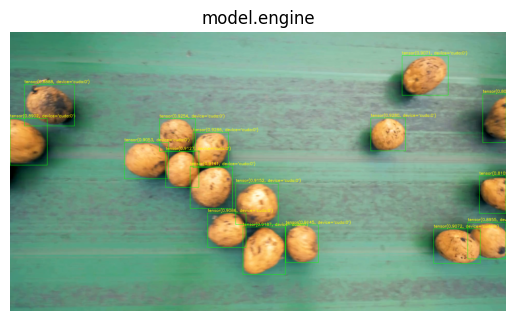

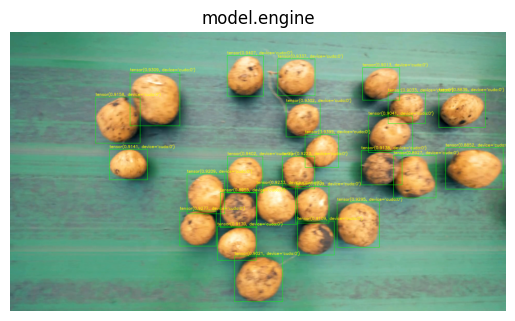

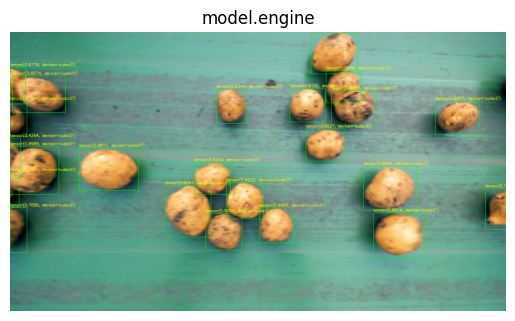

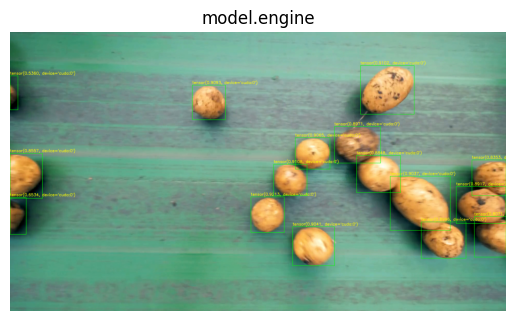

[vost#0:0/rawvideo @ 0x56078326bbc0] Error submitting a packet to the muxer: Broken pipe
    Last message repeated 1 times
[out#0/rawvideo @ 0x560783289300] Error muxing a packet
[out#0/rawvideo @ 0x560783289300] Task finished with error code: -32 (Broken pipe)
[out#0/rawvideo @ 0x560783289300] Terminating thread with return code -32 (Broken pipe)
[out#0/rawvideo @ 0x560783289300] Error writing trailer: Broken pipe
[out#0/rawvideo @ 0x560783289300] Error closing file: Broken pipe


In [169]:
with ffmpegcv.VideoCapture('video.mp4') as cap:

    for iframe, frame in enumerate(cap):
        if iframe > 100:
            break

        results = model.predict(frame, verbose=False)
        # Draw boxes
        if iframe % 30 == 0:
            frame_with_boxes = draw_boxes(frame, results[0], class_names='potato')

            # Show with matplotlib
            plt.imshow(cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(f"model.engine")
            plt.axis('off')
            plt.show()

In [60]:
imgs = cv2.imread('frame.jpg')

In [61]:
model = YOLO("Models/best.pt")
results = model.predict(imgs, imgsz=640, conf=0.5)
torch_outputs = results[0].boxes.data.cpu().numpy()  # Тензоры с боксами


0: 384x640 17 potatos, 66.6ms
Speed: 2.2ms preprocess, 66.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [86]:
torch_outputs.shape

(17, 6)

In [ ]:
def preprocess(image):
    input_name = 'images'
    input_shape = (1, 3, 640, 640)
    input_dtype = 'FP32'

    original_h, original_w = image.shape[:2]
    scale_w = original_w / 640.0
    scale_h = original_h / 640.0

    input_data = (cv2.resize(image, (640, 640)) / 255.0).astype(triton_to_np_dtype(input_dtype))
    input_data = input_data.transpose(2, 0, 1)  # (C, H, W)
    input_data = np.expand_dims(input_data, axis=0)  # (1, C, H, W)

    infer_input = InferInput(input_name, input_shape, input_dtype)
    infer_input.set_data_from_numpy(input_data)

    return infer_input, (scale_w, scale_h)

In [159]:
import cv2
import numpy as np
import onnxruntime as ort

# Загрузка изображения
img = cv2.imread("frame.jpg")  # shape: (H, W, 3)

# Предобработка для YOLOv8 ONNX-модели
def preprocess(img):
    # Изменение размера до 640x640
    img = cv2.resize(img, (640, 640))
    
    # Конвертация BGR → RGB (если требуется)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Транспонирование HWC → CHW и добавление оси батча
    img = np.transpose(img, (2, 0, 1))  # CHW
    img = np.expand_dims(img, 0)         # BCHW
    img = img.astype(np.float32)         # FP32
    
    # Нормализация (если модель ожидает значения 0-1)
    img /= 255.0
    
    return img

# Применяем предобработку
preprocessed_imgs = preprocess(img)  # Теперь переменная определена

# Запуск инференса
sess = ort.InferenceSession("Models/tets/best.onnx")
onnx_outputs = sess.run(["output0"], {"images": preprocessed_imgs})

In [117]:
import tensorrt as trt
from polygraphy.logger import G_LOGGER
from polygraphy.backend.common import BytesFromPath
from polygraphy.backend.trt import EngineFromBytes, TrtRunner

# This is a logger for all TensorRT events. Restrict it to only show
# messages of WARNING severity and above.
cuda_logger = trt.Logger(trt.Logger.WARNING)

# This is our CUDA runtime.
cuda_runtime = trt.Runtime(cuda_logger)

# This sets Polygraphy's logger to show only warnings and errors.
G_LOGGER.module_severity = 30

In [136]:
model = TrtRunner(  
  EngineFromBytes(
    serialized_engine=BytesFromPath("model_trt/model_det/1/model.plan"),
    runtime=cuda_runtime,
  )
)

model.activate()  # Activate the engine.

In [137]:
def local_trt(img):

    model.activate()  # Activate the engine.
    input_dict = {"images": img}

    # Run inference!
    output = model.infer(feed_dict=input_dict)

    # Get output tensor.
    tensor_output = output["output0"]  # See the name of your output layer using netron.
    return tensor_output


In [119]:
# Use numpy to create a dummy input.
import numpy as np
x  = preprocess(img) 

# Form your data as a dictionary that specifies the input for which
# each tensor corresponds.
input_dict = {"images": x}

# Run inference!
output = model.infer(feed_dict=input_dict)

# Get output tensor.
tensor_output = output["output0"]  # See the name of your output layer using netron.

# Remember to deactivate your model to avoid memory leaks.
model.deactivate()

In [84]:
tensor_output.shape

(1, 5, 8400)

In [102]:
!polygraphy convert Models/best.onnx -o Models/model.plan \
  --trt-min-shapes "images:[1,3,640,640]" \
  --trt-opt-shapes "images:[10,3,640,640]" \
  --trt-max-shapes "images:[20,3,640,640]" \
  --trt-outputs "output0" \
  --onnx-outputs "output0"

[I] TF32 is disabled by default. Turn on TF32 for better performance with minor accuracy differences.
[I] Configuring with profiles:[
        Profile 0:
            {images [min=[1, 3, 640, 640], opt=[10, 3, 640, 640], max=[20, 3, 640, 640]]}
    ]
[W] profileSharing0806 is on by default in TensorRT 10.0. This flag is deprecated and has no effect.
[I] Building engine with configuration:
    Flags                  | []
    Engine Capability      | EngineCapability.STANDARD
    Memory Pools           | [WORKSPACE: 15985.12 MiB, TACTIC_DRAM: 15985.12 MiB, TACTIC_SHARED_MEMORY: 1024.00 MiB]
    Tactic Sources         | [EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [PROFILE_SHARING_0806]
[I] Finished engine building in 84.366 seconds


In [89]:
onnx_outputs.shape

AttributeError: 'list' object has no attribute 'shape'

In [161]:
diff = np.abs(onnx_outputs[0] - tensor_output)
print("Максимальное расхождение:", np.max(diff))
print("Среднее расхождение:", np.mean(diff))
print("Индексы топ-5 максимальных расхождений:", np.unravel_index(np.argsort(diff.flatten())[-5:], diff.shape))

Максимальное расхождение: 0.0051879883
Среднее расхождение: 3.6619505e-05
Индексы топ-5 максимальных расхождений: (array([0, 0, 0, 0, 0]), array([3, 2, 2, 2, 2]), array([8294, 8233, 8236, 8235, 7648]))


In [121]:
diff = np.abs(onnx_outputs[0] - tensor_output)
print("Максимальное расхождение:", np.max(diff))  # Например: 0.043
print("Среднее расхождение:", np.mean(diff))      # Например: 0.0007
print("Индексы топ-5 максимальных расхождений:", np.unravel_index(np.argsort(diff.flatten())[-5:], diff.shape))

Максимальное расхождение: 0.0040283203
Среднее расхождение: 3.2422286e-05
Индексы топ-5 максимальных расхождений: (array([0, 0, 0, 0, 0]), array([2, 3, 2, 2, 2]), array([8232, 8294, 8233, 8235, 7648]))


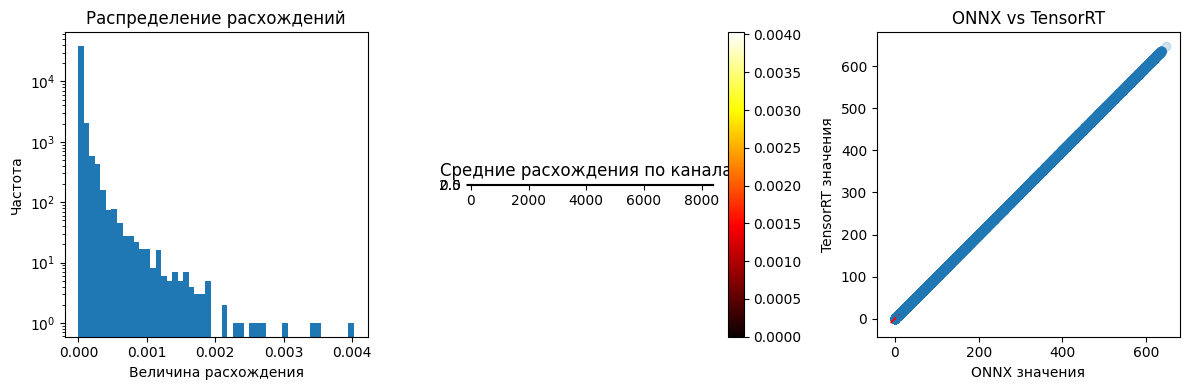

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 1. Гистограмма расхождений
plt.subplot(1, 3, 1)
plt.hist(diff.flatten(), bins=50, log=True)
plt.title('Распределение расхождений')
plt.xlabel('Величина расхождения')
plt.ylabel('Частота')

# 2. Тепловая карта
plt.subplot(1, 3, 2)
plt.imshow(np.mean(diff, axis=0), cmap='hot')
plt.colorbar()
plt.title('Средние расхождения по каналам')

# 3. Точечная диаграмма
plt.subplot(1, 3, 3)
plt.scatter(onnx_outputs[0].flatten(), tensor_output.flatten(), alpha=0.1)
plt.plot([-10,10], [-10,10], 'r--')
plt.title('ONNX vs TensorRT')
plt.xlabel('ONNX значения')
plt.ylabel('TensorRT значения')

plt.tight_layout()
plt.show()

In [123]:
!polygraphy run best.onnx --trt --load-inputs inputs.json --validate

[W] Model path does not exist: best.onnx
[I] RUNNING | Command: /home/paperspace/project_conveyer/.venv/bin/polygraphy run best.onnx --trt --load-inputs inputs.json --validate
[I] Loading input data from inputs.json
Traceback (most recent call last):
  File "/home/paperspace/project_conveyer/.venv/bin/polygraphy", line 8, in <module>
    sys.exit(main())
  File "/home/paperspace/project_conveyer/.venv/lib/python3.10/site-packages/polygraphy/tools/_main.py", line 73, in main
    status = selected_tool.run(args)
  File "/home/paperspace/project_conveyer/.venv/lib/python3.10/site-packages/polygraphy/tools/base/tool.py", line 179, in run
    status = self.run_impl(args)
  File "/home/paperspace/project_conveyer/.venv/lib/python3.10/site-packages/polygraphy/tools/run/run.py", line 235, in run_impl
    exec(str(script))
  File "<string>", line 16, in <module>
  File "/home/paperspace/project_conveyer/.venv/lib/python3.10/site-packages/polygraphy/json/serde.py", line 282, in wrapped
    retur

In [125]:
import onnx
model = onnx.load("Models/best.onnx")
problematic_ops = [node.op_type for node in model.graph.node if node.op_type in ['Resize', 'GridSample']]
print("Потенциально проблемные операции:", set(problematic_ops))

Потенциально проблемные операции: {'Resize'}


In [126]:
!polygraphy inspect model model_trt/model_det/1/model.plan --show layers | grep -i "resize"

    Layer 87   | /model.10/Resize [Op: Resize]
         -> {/model.10/Resize_output_0 [dtype=float32, shape=(-1, 256, 40, 40), Format: Float]}
    Layer 88   | /model.10/Resize_output_0 copy [Op: Reformat]
        {/model.10/Resize_output_0 [dtype=float32, shape=(-1, 256, 40, 40), Format: Float]}
    Layer 99   | /model.13/Resize [Op: Resize]
         -> {/model.13/Resize_output_0 [dtype=float32, shape=(-1, 128, 80, 80), Format: Float]}
    Layer 100  | /model.13/Resize_output_0 copy [Op: Reformat]
        {/model.13/Resize_output_0 [dtype=float32, shape=(-1, 128, 80, 80), Format: Float]}


In [131]:
import numpy as np

In [135]:
print(np.max(np.abs(onnx_outputs[0] - tensor_output)))
print(np.count_nonzero(np.abs(onnx_outputs[0] - tensor_output) > 0.001))


0.0040283203
90


In [133]:
np.testing.assert_allclose(onnx_outputs[0], tensor_output, rtol=1e-5, atol=1e-3)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0.001

Mismatched elements: 7 / 42000 (0.0167%)
Max absolute difference:   0.0040283
Max relative difference:      4.4036
 x: array([[[     27.631,      30.619,      28.281, ...,      506.84,      550.06,      568.03],
        [     30.692,      24.215,      18.904, ...,      603.17,      609.63,      608.14],
        [     54.814,      62.569,      50.788, ...,      271.51,      252.75,      205.18],...
 y: array([[[     27.631,      30.619,      28.281, ...,      506.84,      550.06,      568.03],
        [     30.692,      24.215,      18.904, ...,      603.17,      609.63,      608.14],
        [     54.814,      62.569,      50.787, ...,      271.51,      252.75,      205.18],...

In [134]:
print(np.max(np.abs(x - y)))
print(np.count_nonzero(np.abs(x - y) > 0.001))


NameError: name 'y' is not defined

In [127]:
import numpy as np
# Для численного сравнения (допустимая погрешность ~1e-3)
np.testing.assert_allclose(onnx_outputs[0], tensor_output)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 25022 / 42000 (59.6%)
Max absolute difference:   0.0040283
Max relative difference:      4.4036
 x: array([[[     27.631,      30.619,      28.281, ...,      506.84,      550.06,      568.03],
        [     30.692,      24.215,      18.904, ...,      603.17,      609.63,      608.14],
        [     54.814,      62.569,      50.788, ...,      271.51,      252.75,      205.18],...
 y: array([[[     27.631,      30.619,      28.281, ...,      506.84,      550.06,      568.03],
        [     30.692,      24.215,      18.904, ...,      603.17,      609.63,      608.14],
        [     54.814,      62.569,      50.787, ...,      271.51,      252.75,      205.18],...